#### sequence-to-sequence
#### encoder
#### decoder


input   -> Embeddings -> Encoder -> Decoder -> Dense -> output

In [3]:
## import libraries and packages
import string
import re
from numpy import array,argmax,random,take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_colwidth",200)

In [4]:
## function to read raw text file
def read_text(filename):
    file=open(filename,mode="rt",encoding='utf-8')
    text=file.read()
    file.close()
    return text

In [5]:
### split the text into sentences
def to_lines(text):
    sents=text.strip().split('\n')
    sents=[i.split('\t') for i in sents]
    return sents

In [6]:
data=read_text('deu.txt')
deu_eng=to_lines(data)
deu_eng=array(deu_eng)

In [7]:
deu_eng=deu_eng[:50000,:]

In [8]:
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['I like listening to music.', 'Ich höre gerne Musik.'],
       ['I like playing basketball.', 'Ich spiele gern Basketball.'],
       ["I like reading Tom's blog.",
        'Ich lese gern in Toms Netztagebuch.']], dtype='<U380')

In [9]:
#### Remove punctuation
deu_eng[:,0]=[s.translate(str.maketrans('','',string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1]=[s.translate(str.maketrans('','',string.punctuation)) for s in deu_eng[:,1]]

In [10]:
deu_eng

array([['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ...,
       ['I like listening to music', 'Ich höre gerne Musik'],
       ['I like playing basketball', 'Ich spiele gern Basketball'],
       ['I like reading Toms blog', 'Ich lese gern in Toms Netztagebuch']],
      dtype='<U380')

In [11]:
### convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0]=deu_eng[i,0].lower()
    deu_eng[i,1]=deu_eng[i,1].lower()

In [12]:
deu_eng

array([['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ['run', 'lauf'],
       ...,
       ['i like listening to music', 'ich höre gerne musik'],
       ['i like playing basketball', 'ich spiele gern basketball'],
       ['i like reading toms blog', 'ich lese gern in toms netztagebuch']],
      dtype='<U380')

### Text to sequence conversion

In [13]:
### empty lists
eng_l=[]
deu_l=[]

In [14]:
## Populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))
for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [15]:
length_df=pd.DataFrame({'eng':eng_l,'deu':deu_l})

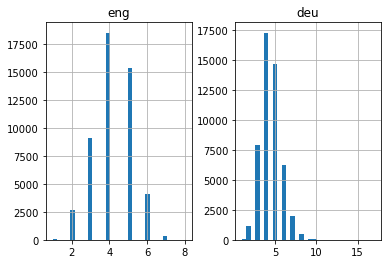

In [16]:
length_df.hist(bins=30)
plt.show()

In [17]:
### build a tokenizer
def tokenization(lines):
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


In [18]:
## prepare english tokenizer
eng_tokenizer=tokenization(deu_eng[:,0])
eng_vocab_size=len(eng_tokenizer.word_index)+1
eng_length=8
eng_vocab_size

6794

In [19]:
### Prepare Deutch tokenizer
deu_tokenizer=tokenization(deu_eng[:,1])
deu_vocab_size=len(deu_tokenizer.word_index)+1
deu_length=8
deu_vocab_size

11814

In [20]:
### Function to prepare the sequences
## encode and pad sequences
def encode_sequences(tokenizer,length,lines):
    seq=tokenizer.texts_to_sequences(lines)
    seq=pad_sequences(seq,maxlen=length,padding="post")
    return seq

### Model Building

In [21]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(deu_eng,test_size=0.2,random_state=12)

In [22]:
### prepare training data
trainX=encode_sequences(deu_tokenizer,deu_length,train[:,1])
trainY=encode_sequences(eng_tokenizer,eng_length,train[:,0])


In [23]:
### prepare validation data
testX=encode_sequences(deu_tokenizer,deu_length,test[:,1])
testY=encode_sequences(eng_tokenizer,eng_length,test[:,0])


In [24]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [25]:
model=build_model(deu_vocab_size,eng_vocab_size,deu_length,eng_length,512)

In [26]:
rms=optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms,loss="sparse_categorical_crossentropy")

In [27]:
filename='model.h1'

In [28]:
checkpoint=ModelCheckpoint(filename,monitor="val_loss",verbose=1,save_best_only=True,mode="min")

In [29]:
history=model.fit(trainX,trainY.reshape(trainY.shape[0],trainY.shape[1],1),
                 epochs=2,batch_size=512,validation_split=0.2,callbacks=[checkpoint],verbose=1)

Epoch 1/2
63/63 [==============================] - ETA: 0s - loss: 3.8568
Epoch 1: val_loss improved from inf to 3.26248, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1\assets


INFO:tensorflow:Assets written to: model.h1\assets


63/63 [==============================] - 427s 6s/step - loss: 3.8568 - val_loss: 3.2625
Epoch 2/2
63/63 [==============================] - ETA: 0s - loss: 3.2114
Epoch 2: val_loss improved from 3.26248 to 3.18225, saving model to model.h1


INFO:tensorflow:Assets written to: model.h1\assets


INFO:tensorflow:Assets written to: model.h1\assets


63/63 [==============================] - 327s 5s/step - loss: 3.2114 - val_loss: 3.1822


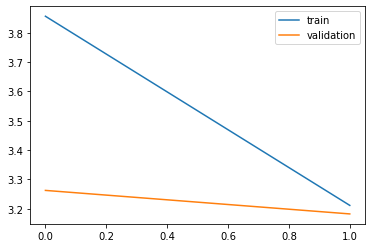

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [33]:
model = load_model('model.h1')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))

313/313 [==============================] - 62s 174ms/step
